# Introduction

This notebook will concentrate on the findings of the previous notebook : 'ProbaDingue'.

The main finding was that we need to condition the r.v. $S_{t;N}$ on the past observations only and not on past $S_{t;N}$. This render the analysis much more simpler and is better able to exploit all the information.

We are going to extend the conditional distribution of $S_{t;N}$ by allowing more dependence on past observations $X_t$. This will require to enhance the MA(1) model to other types of models.

For the first time we are also going to analyse empirical evidence. Namely we are going to take some time series from the Forex or the stock market. But first the forex since it is the most accessible one. 

Since I am trying to build a trading model, I need somewhat high-frequency data. I'll first take 15min EURUSD as empirical data.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numba as nb

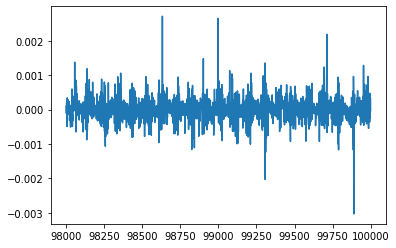

In [2]:
T = 2000
eurusd = pd.read_csv('EURUSDM15.csv', sep=';', encoding='utf_16_le', names=['date', 'open', 'high', 'low', 'close', 'd5', 'd6'])['close']
# eurusd.iloc[-1000:].plot()
eurusd = np.log1p(eurusd.pct_change())
eurusd = eurusd.iloc[-2000:]
eurusd.plot()

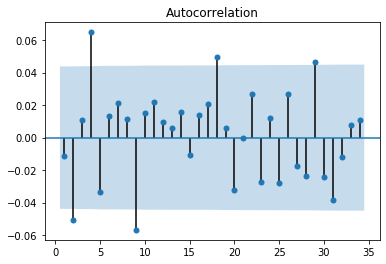

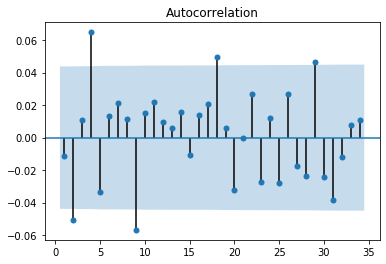

In [3]:
sm.graphics.tsa.plot_acf(eurusd, zero=False)

From those graph, we can see some seasonality in the 15 minutes EURUSD. The ACF say that not much information is available in the lag values of the observations. There are some significant coefficients, but they are rather small.

I believe the current observation is much more influence by the 'big picture'. I mean the bigger structure appearing in the series, namely the trends, the retracements, ... 
However those bigger structure have an origine in the trading history. 

What I must do is try to discover those structrue with the scientific reasoning. I should try to build an understanding of the price movements from the ground up and not using my previous knowledge of market's behavior.


# Some Facts

* The most fundamental truth I know about trading is that I must buy when the price is going up.

* If I look at some chart, I see that they are some down bars in the middle of a trend. Those down bars don't effect the fact that the price is still going up in the next periods.

* I also know that volatility is good and bad since with it we can have tremendeous returns but also losses.

* In order to construct a model, there must be an invariant somewhere.

# Effects of neighours

This first model will try to encapsulate the information I can obtain from neighouring prices. I can observe that, isolately, each bar doesn't contain much information. I believe this is one reason why the ACF doesn't help much to extract information from past obserations. However If we regroup smartly each bar in a bigger set, together they have a better meaning. 

Each bar can be part of multiple bigger sets. We should try to find those bigger sets.

The idea would be that an isolate bar has no effect on his neighours. However together they have an impact on each of them. The Group has an influence on the singular bar.

What is a Group ?

A group is constituted of minimum 2 members. All members of a group must at least share a common feature, otherwise they would not be part of the group.

An important question is : What is the criterion that defines a group ? In other words, what is linking every members of the group ? Usually, the criterion used to judge the link between members is the covariance. However in our case the effect between 2 members may not be the same in both directions. It remains to find a good alternative

What kind of sets can we find ?
Groups may not be present all the time. We may have period of total randomness

# First model : The Trend Group

This first model will try to capture the group with a common trend. Some bars seems to be part of a common trend. In other words, there seems to exists a group where positive returns dominates over negative ones. Sometime negative returns inside those groups are insignificant for the integrity of those group. However even those negative isolated bars are part of the group, they should therefore share something with the group.

This first group comes from my intuition by looking at charts. However I should try to develop a method for finding some other potential groups

The most simple model I could think of when it comes to this group is the following, 


\begin{align*}
    \large
    X_t = \epsilon_t + \alpha G_t && \text{ where } \epsilon_t \sim GWN(0,\sigma^2_\epsilon)
\end{align*}

This models the time series as a white noise with a constant which is not always active. 


There are 2 important parameters in this model : 

* $\alpha \in (-\infty, \infty)$ : which gives the intensity of the trend group. It is first assumed constant.
* $G_t \in \{0,1\}$ : which gives us when the trend group is active. $1$ if the group is active at time $t$.

The effect of the group "trend" on the observation is to shift its expectation positively or negatively. 

The parameter $G_t$ must depend on past and future values since, by definition, the group affects multiple neighbouring observations. We must at least have some kind of clustering of the same values of $G_t$.


The random variable $G_t$ is a Bernoulli r.v. which has a probability $\pi$ of being $1$. However we need that probability to depend on previous probabilities (at least 1) if we want to have that kind of clustering. We then make that probability follow an AR(1) model (could be extended to AR(p)). Note that $\pi_t$ is a probability and that the AR(1) does not provide values between 0 and 1. Therefore we pass that AR(1) model into a sigmoid function $f: \mathbb{R} \rightarrow [0,1]$

\begin{align*}
    G_t \sim Bernoulli(\pi_t)\\
    \pi_{t+1} = f(z_t) && \text{ where } f:= \text{ sigmoid }\\
    z_{t+1} = \omega + \phi z_t + \nu_t && \text{ where } \nu \sim GWN(0, \sigma^2_{\nu})
\end{align*}

In [54]:
def sigmoid(x, lam:np.float64):
    return 1.0 / (1.0 + np.exp(-lam*x))

In [64]:
def bernoulli(p):
    return (np.random.uniform(0,1) <= p)*1.0

In [44]:
def AR(phi:np.float64, const:np.float64=0.0, var_e:np.float64=1.0):
    previous_value = np.random.normal(0.0, var_e)
    
    while True:
        current_innov = np.random.normal(0.0, var_e)
        current_value = const + phi * previous_value + current_innov
        yield current_value
        previous_value = current_value

In [97]:
def G_process(phi:np.float64, const:np.float64=0.0, var_e:np.float64=1.0, lam:np.float64=1.0):
    ar_process = AR(phi, const, var_e)
    
    while True:
        current_pi = sigmoid(next(ar_process), lam)
        yield bernoulli(current_pi)

In [127]:
def trend_process(alpha:np.float64, phi:np.float64, const:np.float64=0.0, var_e:np.float64=1.0, lam:np.float64=1.0):
    g_process = G_process(phi, const, var_e, lam)
    while True:
        yield np.random.normal(0,1) + alpha * next(g_process)

In [128]:
def sample_process(process, n:int, *args):
    sample = np.empty((n, ), dtype=np.float64)
    process = process(*args)
    
    for i in range(n):
        sample[i] = next(process)
    
    return sample

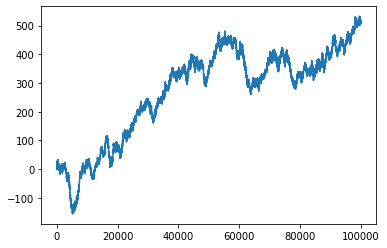

In [211]:
sample = sample_process(trend_process, 1000, 0.0, 0.9, 0.0, 1.0, 10)
# sample = sample_process(AR, 1000, 0.7)
plt.plot(np.cumsum(sample))

# x = np.linspace(sc.norm.ppf(0.001), sc.norm.ppf(0.999), 100)
# fig, ax = plt.subplots(1,1,figsize=(12, 8))
# ax.plot(x, sc.norm.pdf(x), 'r', lw=4)
# ax.hist(sample, bins=100, density=True)

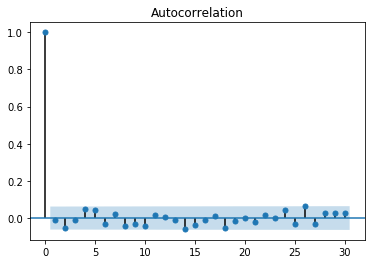

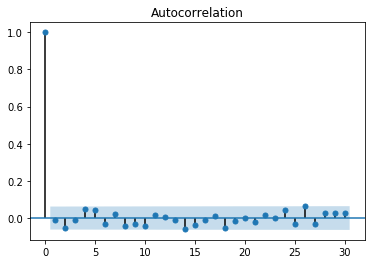

In [186]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(sample)